In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **data_clean**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/data/dataset.csv', delimiter=',')

## read data (both fake and real news)

In [ ]:
fake_and_true = pd.read_csv('/content/drive/My Drive/data/fake_or_real_news.csv', delimiter=',')
fake = pd.read_csv('/content/drive/My Drive/data/Fake.csv', delimiter = ',')
true = pd.read_csv('/content/drive/My Drive/data/True.csv', delimiter = ',')
fake_and_true.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake_and_true["text"] = fake_and_true["title"] + " " + fake_and_true["text"]

fake_and_true.loc[fake_and_true["label"]=='FAKE',"label"] = 0
fake_and_true.loc[fake_and_true["label"]=='REAL',"label"]= 1
fake_and_true.drop(columns= ['title','Unnamed: 0'], inplace=True)

In [ ]:
fake['label']= 0
true['label']= 1

dataset =pd.DataFrame()
dataset = true.append(fake)

In [ ]:
dataset["text"] = dataset["title"] + " " + dataset["text"]
dataset.drop(columns= ['title','subject', 'date'], inplace=True)

dataset = pd.concat([fake_and_true, dataset], ignore_index=True)

In [ ]:
dataset['label'] = dataset['label'].astype('int')

In [ ]:
fake_text = dataset.loc[dataset['label']==0,"text"].tolist()
true_text = dataset.loc[dataset['label']==1,"text"].tolist()

In [ ]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

In [ ]:
fake_string = combine_text(fake_text)
true_string = combine_text(true_text)

In [ ]:
import re
import nltk
import string
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

def clean_text(text):
  stemmed_text = []
  porter_stemmer = PorterStemmer()
  # remove words inside brackets, punctuation and words that have number in them
  result = re.sub('[^a-zA-Z]', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  result = result.lower()
  result = result.split()
  result = [r for r in result if r not in set(stopwords.words('english'))]
  stemmed_result = [porter_stemmer.stem(r) for r in result]
  stemmed_text.append(" ".join(stemmed_result))
  return stemmed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
fake_cleaned_text = clean_text(fake_string)
true_cleaned_text = clean_text(true_string)

In [ ]:
combined_clean_text_dict = {"fake":fake_cleaned_text, "true":true_cleaned_text}
data_df = pd.DataFrame.from_dict(combined_clean_text_dict, orient='index', columns=['text'])

In [ ]:
data_df.head()

,text
fake,smell hillari fear daniel greenfield shillman ...
true,kerri go pari gestur sympathi u secretari stat...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_df.text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_df.index
data_dtm

,aa,aaa,aaaaaaaand,aaaaackkk,aaaaapkfhk,aaaahhhh,aaaand,aaaarrgh,aaab,aaahhh,aaarf,aab,aaba,aabfsv,aabg,aabo,aaccord,aachen,aacnr,aadhaar,aadhar,aadl,aadmi,aae,aaeeb,aaf,aafn,aag,aagi,aagxdwkrjpq,aah,aahd,aahi,aahwuhvvnh,aai,aaib,aaingr,aaj,aaja,aakar,...,zye,zyf,zygot,zyi,zyifjwyfdh,zyj,zyjdjtknan,zyklon,zymo,zynga,zyomso,zypri,zyri,zytnwhvr,zyuganov,zyz,zz,zzbluecomet,zzg,zzgaahg,zzi,zzjjpdaivn,zzll,zzlo,zzn,zzomtmd,zzpkpmpp,zzpx,zzpxelb,zzqvyk,zzsg,zztain,zztw,zzucqevt,zzuml,zzywyr,zzz,zzzzaaaacccchhh,zzzzzzzz,zzzzzzzzzzzzz
fake,57,11,1,1,1,1,1,1,0,1,1,10,0,0,4,0,1,3,1,0,1,6,2,2,5,2,2,1,1,1,0,0,1,1,0,2,1,5,1,1,...,1,1,2,2,2,1,2,1,1,2,1,0,0,2,2,1,7,1,2,1,2,1,1,1,1,1,1,1,1,2,1,1,1,1,3,2,1,3,1,1
true,24,9,0,0,0,0,0,0,1,0,0,5,1,1,0,2,0,2,0,30,2,0,0,0,0,10,0,0,0,0,1,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3,0,5,1,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## count most used words

In [ ]:
# Find the top 30 words used by fake news and true news
data_dtm = data_dtm.transpose()
top_dict = {}
for c in data_dtm.columns:
    top = data_dtm[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'fake': [('trump', 96748),
  ('said', 37973),
  ('presid', 34937),
  ('peopl', 32800),
  ('state', 31767),
  ('clinton', 28564),
  ('like', 26673),
  ('say', 24836),
  ('time', 24267),
  ('obama', 24030),
  ('year', 23727),
  ('american', 22761),
  ('hillari', 21522),
  ('donald', 20611),
  ('report', 19245),
  ('republican', 19086),
  ('new', 18988),
  ('make', 18877),
  ('video', 18871),
  ('elect', 18870),
  ('right', 18216),
  ('news', 17388),
  ('support', 17050),
  ('nation', 16593),
  ('white', 16289),
  ('use', 16174),
  ('imag', 15198),
  ('know', 15143),
  ('campaign', 15087),
  ('democrat', 15078)],
 'true': [('said', 116286),
  ('trump', 76732),
  ('state', 49177),
  ('presid', 37816),
  ('republican', 32350),
  ('reuter', 29247),
  ('year', 28836),
  ('say', 25970),
  ('govern', 24225),
  ('new', 23744),
  ('hous', 22953),
  ('democrat', 22952),
  ('elect', 22482),
  ('peopl', 21805),
  ('clinton', 21532),
  ('parti', 20898),
  ('senat', 20237),
  ('unit', 18824),
  ('cam

In [ ]:
# add the top 30 word from each label
words = []
for label in data_dtm.columns:
    top = [word for (word, count) in top_dict[label]]
    for t in top:
        words.append(t)
words

['trump',
 'said',
 'presid',
 'peopl',
 'state',
 'clinton',
 'like',
 'say',
 'time',
 'obama',
 'year',
 'american',
 'hillari',
 'donald',
 'report',
 'republican',
 'new',
 'make',
 'video',
 'elect',
 'right',
 'news',
 'support',
 'nation',
 'white',
 'use',
 'imag',
 'know',
 'campaign',
 'democrat',
 'said',
 'trump',
 'state',
 'presid',
 'republican',
 'reuter',
 'year',
 'say',
 'govern',
 'new',
 'hous',
 'democrat',
 'elect',
 'peopl',
 'clinton',
 'parti',
 'senat',
 'unit',
 'campaign',
 'nation',
 'offici',
 'countri',
 'report',
 'support',
 'vote',
 'told',
 'obama',
 'time',
 'washington',
 'polit']

In [ ]:
from collections import Counter

Counter(words).most_common()

[('trump', 2),
 ('said', 2),
 ('presid', 2),
 ('peopl', 2),
 ('state', 2),
 ('clinton', 2),
 ('say', 2),
 ('time', 2),
 ('obama', 2),
 ('year', 2),
 ('report', 2),
 ('republican', 2),
 ('new', 2),
 ('elect', 2),
 ('support', 2),
 ('nation', 2),
 ('campaign', 2),
 ('democrat', 2),
 ('like', 1),
 ('american', 1),
 ('hillari', 1),
 ('donald', 1),
 ('make', 1),
 ('video', 1),
 ('right', 1),
 ('news', 1),
 ('white', 1),
 ('use', 1),
 ('imag', 1),
 ('know', 1),
 ('reuter', 1),
 ('govern', 1),
 ('hous', 1),
 ('parti', 1),
 ('senat', 1),
 ('unit', 1),
 ('offici', 1),
 ('countri', 1),
 ('vote', 1),
 ('told', 1),
 ('washington', 1),
 ('polit', 1)]

In [ ]:
from sklearn.feature_extraction import text

# add the common words to stop word list
new_stop_words = [word for word, count in Counter(words).most_common() if count >=2]
stop_words = text.ENGLISH_STOP_WORDS.union(new_stop_words)

# repeat the process using counterVectorizer
cv = CountVectorizer(stop_words = stop_words)
data_cv = cv.fit_transform(data_df.text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_df.index

data_dtm = data_dtm.transpose()
top_dict = {}
for c in data_dtm.columns:
    top = data_dtm[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'fake': [('like', 26673),
  ('american', 22761),
  ('hillari', 21522),
  ('donald', 20611),
  ('make', 18877),
  ('video', 18871),
  ('right', 18216),
  ('news', 17388),
  ('white', 16289),
  ('use', 16174),
  ('imag', 15198),
  ('know', 15143),
  ('want', 14806),
  ('media', 14638),
  ('vote', 14327),
  ('countri', 14326),
  ('hous', 14178),
  ('america', 13944),
  ('govern', 13612),
  ('work', 13516),
  ('polit', 13470),
  ('think', 13226),
  ('day', 13110),
  ('twitter', 12904),
  ('mani', 12623),
  ('come', 12618),
  ('offic', 12458),
  ('way', 12183),
  ('law', 11560),
  ('thing', 11190)],
 'true': [('reuter', 29247),
  ('govern', 24225),
  ('hous', 22953),
  ('parti', 20898),
  ('senat', 20237),
  ('unit', 18824),
  ('offici', 17975),
  ('countri', 17472),
  ('vote', 17195),
  ('told', 17156),
  ('washington', 15027),
  ('polit', 14878),
  ('includ', 14844),
  ('secur', 14098),
  ('like', 13907),
  ('group', 13897),
  ('week', 13706),
  ('percent', 13570),
  ('white', 13565),
  

In [ ]:
# fakew news tends to use more verbs and adverbs, and true news uses more adjectives and nouns

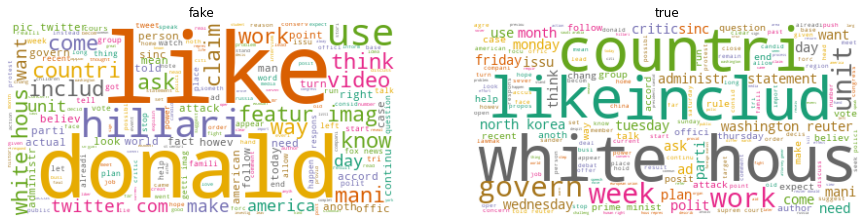

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(stopwords = stop_words, background_color = "white", colormap = "Dark2", max_font_size = 100, random_state = 40)
plt.rcParams['figure.figsize'] = [32,160]


for index, label in enumerate(data_dtm.columns):
    wc.generate(data_df.text[label])
    plt.subplot(3,4, index+1)
    plt.imshow(wc,interpolation = "bilinear")
    plt.axis("off")
    plt.title(label)
    
plt.show()

## count punctuations

In [ ]:
import string

pun_count_fake, pun_count_true = 0,0

for i in fake_string:
    if i in string.punctuation:
        pun_count_fake+=1
for i in true_string:
    if i in string.punctuation:
        pun_count_true+=1
pun_count_fake

1742552

In [ ]:
pun_count_true

1549149

In [ ]:
# fake news use 27.6798% more puctuations than true news

## count number of stop words

In [ ]:
import nltk
from nltk.corpus import stopwords
stopword_count_fake, stopword_count_true = 0,0

for i in fake_string.split():
    if i in set(stopwords.words('english')):
        stopword_count_fake+=1
for i in true_string.split():
    if i in set(stopwords.words('english')):
        stopword_count_true+=1
stopword_count_fake

4834926

In [ ]:
stopword_count_true

4132375

## count number of capital letters

In [ ]:
cap_count_fake = sum(1 for c in fake_string if c.isupper())
cap_count_true = sum(1 for c in true_string if c.isupper())

In [ ]:
cap_count_fake

3583315

In [ ]:
cap_count_true

2469310